#Lab 8: Learning from Images

---


## Part 1: Butterfly Classification <br>
Train, Test data set for 10 butterfly species. All images are 224 X 224 X 3 in jpg format.

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from itertools import chain
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder

In [ ]:
# Define the image preprocessing pipeline
Butterfly_trans = transforms.Compose([        # composes several transforms together
    transforms.Resize((224, 224)),
    transforms.ToTensor() # ToTensor() converts images to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
])

In [ ]:
# Loading images and pass the images through our preprocessing pipeline
train_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/train_top10', transform=Butterfly_trans)
test_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/test_top10', transform=Butterfly_trans)

In [ ]:
len(train_butterfly10.classes)

10

In [ ]:
# Examine the sizes of training and test data
print(len(train_butterfly10), len(test_butterfly10))

1175 50


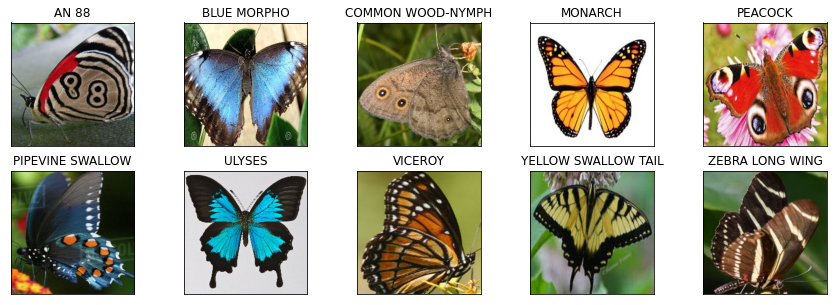

In [ ]:
class_names = ['AN 88','BLUE MORPHO','COMMON WOOD-NYMPH','MONARCH','PEACOCK','PIPEVINE SWALLOW','ULYSES','VICEROY','YELLOW SWALLOW TAIL','ZEBRA LONG WING']

fig = plt.figure(figsize=(15,5))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in test_butterfly10 if label == i)
    plt.imshow(img.permute(1, 2, 0))
plt.show()

In [ ]:
# Examine the tensor of a zebra long wing image
print(img.shape)
print(img)

torch.Size([3, 224, 224])
tensor([[[0.3961, 0.3961, 0.4000,  ..., 0.4353, 0.4275, 0.4314],
         [0.4039, 0.4039, 0.4000,  ..., 0.4314, 0.4235, 0.4196],
         [0.4118, 0.4078, 0.4039,  ..., 0.4431, 0.4353, 0.4275],
         ...,
         [0.0392, 0.0392, 0.0392,  ..., 0.4706, 0.4941, 0.5020],
         [0.0392, 0.0392, 0.0392,  ..., 0.4118, 0.4353, 0.4471],
         [0.0392, 0.0392, 0.0392,  ..., 0.3608, 0.3804, 0.3882]],

        [[0.5294, 0.5294, 0.5333,  ..., 0.5647, 0.5608, 0.5725],
         [0.5373, 0.5373, 0.5333,  ..., 0.5647, 0.5569, 0.5608],
         [0.5451, 0.5412, 0.5373,  ..., 0.5765, 0.5686, 0.5686],
         ...,
         [0.0431, 0.0431, 0.0431,  ..., 0.5647, 0.5882, 0.5961],
         [0.0431, 0.0431, 0.0431,  ..., 0.5216, 0.5451, 0.5569],
         [0.0431, 0.0431, 0.0431,  ..., 0.4745, 0.4941, 0.5020]],

        [[0.3843, 0.3843, 0.3882,  ..., 0.3412, 0.3255, 0.3333],
         [0.3922, 0.3922, 0.3882,  ..., 0.3294, 0.3216, 0.3216],
         [0.4078, 0.4039, 0.4000

In [ ]:
# Examine the mean and std of images in the training data
imgs = torch.stack([img_t for img_t, label in train_butterfly10], dim = 3)
print(imgs.view(3,-1).mean(dim=1),imgs.view(3,-1).std(dim=1))

tensor([0.4621, 0.4528, 0.3400]) tensor([0.2884, 0.2767, 0.2862])


In [ ]:
# Define the image preprocessing pipeline to include normalization
Butterfly_trans = transforms.Compose([        # composes several transforms together
    transforms.Resize((224, 224)),
    transforms.ToTensor(), # ToTensor() converts images to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    transforms.Normalize(mean = [0.4621, 0.4528, 0.3400], std = [0.2284, 0.2767, 0.2862])
])

In [ ]:
# Loading images and pass the images through our preprocessing pipeline

train_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/train_top10', transform=Butterfly_trans)
test_butterfly10 = ImageFolder('/content/drive/MyDrive/DL_data/test_top10', transform=Butterfly_trans)



In [ ]:
# Define training and testing data loader, and set batch size to 128
train_loader_butterfly10 = torch.utils.data.DataLoader(train_butterfly10, batch_size=128, shuffle=True)
test_loader_butterfly10 = torch.utils.data.DataLoader(test_butterfly10, batch_size=128, shuffle=False)

In [ ]:
# Build a neural network on training data

class neural_network(nn.Module):
    def __init__(self,  in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        self.network = nn.Sequential(
          nn.Linear(in_size, hidden_size1),
          nn.ReLU(),
          nn.Linear(hidden_size1, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, out_size))

    def forward(self, x):
        x_reshape = x.view(x.shape[0], -1)
        out = self.network(x_reshape)
        return out

In [ ]:
# Define training loop function

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase 
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:

            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 0 or epoch == n_epochs-1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))

In [ ]:
# Model training
torch.manual_seed(0)
model = neural_network(224*224*3, 128, 64, 10)
optimizer_adam = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs= 4, optimizer = optimizer_adam, model = model, loss_fn = loss_fn, train_loader = train_loader_butterfly10)


Epoch 0, Training loss 4.957001566886902
Epoch 1, Training loss 2.3558237075805666
Epoch 2, Training loss 1.7434115290641785
Epoch 3, Training loss 0.9138864010572434


In [ ]:
# Define testing function

def test(model, train_loader, test_loader):
 
  # testing phase
  model.eval()
  predict_train = []
  predict_test = []
  labels_train = []
  labels_test = []

  with torch.no_grad():
      for inputs, labels in train_loader:
          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_train.append(predicted.tolist())
          labels_train.append(labels.tolist())

      for inputs, labels in test_loader:
          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_test.append(predicted.tolist())
          labels_test.append(labels.tolist())

  print("Confusion matrix on train:\n",  confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on train:\n",  classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Confusion matrix on test:\n",  confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on test:\n",  classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))


In [ ]:
# Examine evaluation results

test(model, train_loader_butterfly10, test_loader_butterfly10)

Confusion matrix on train:
 [[120   1   0   0   0   0   0   0   0   0]
 [  0 101   0   1   2   1   0   2   0   0]
 [  2   7 100   1   2   2   1   4   2   7]
 [  2   1   1 123   2   0   0   0   0   0]
 [  1   0   0   1 118   0   0   0   0   0]
 [  1   5   0   0   0 111   2   0   0   1]
 [  0   5   0   0   0   0 115   0   0   0]
 [  1   2   2   1   2   0   0 107   0   0]
 [  0   1   0   0   0   2   0   0 103   1]
 [  1   7   0   0   1   1   1   1   1  95]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       121
           1       0.78      0.94      0.85       107
           0       0.94      0.99      0.96       121
           1       0.78      0.94      0.85       107
           2       0.97      0.78      0.87       128
           3       0.97      0.95      0.96       129
           4       0.93      0.98      0.96       120
           5       0.95      0.93      0.94       120
           6       0

## Part 2: Image Classification with Fashion-MNIST 

Fashion-MNIST is a dataset consisting of a training set of 60,000 examples and a test set of 10,000 examples. <br>
Each example is a 28x28 grayscale image, associated with a label from 10 classes. (https://github.com/zalandoresearch/fashion-mnist) <br>
<br>

Label Description<br>
Each training and test example is assigned to one of the following labels:<br>

0	T-shirt/top<br>
1	Trouser<br>
2	Pullover<br>
3	Dress<br>
4	Coat<br>
5	Sandal<br>
6	Shirt<br>
7	Sneaker<br>
8	Bag<br>
9	Ankle boot<br>

In [ ]:
# Define the image preprocessing pipeline
MNIST_transform = transforms.Compose([transforms.ToTensor()]) # composes several transforms together

In [ ]:
# Loading images and pass the images through our preprocessing pipeline
train_data = datasets.FashionMNIST('/content/drive/MyDrive/DL_data', download = True, train = True, transform=MNIST_transform)
test_data = datasets.FashionMNIST('/content/drive/MyDrive/DL_data', download = True, train = False, transform=MNIST_transform)

In [ ]:
# Examine the sizes of training and test data
print(len(train_data), len(test_data))

60000 10000


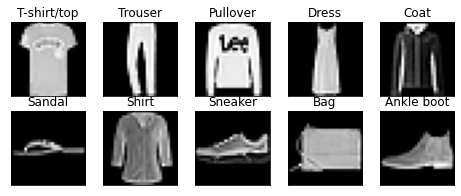

In [ ]:
# Display an example image for each class
class_names = ['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in test_data if label == i)
    plt.imshow(np.squeeze(img), cmap='gray')
plt.show()

In [ ]:
# Examine the tensor of a Ankle boot image
print(img.shape)
print(img)

torch.Size([1, 28, 28])
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000,

In [ ]:
# Examine the mean and std of images in the training data
imgs = torch.stack([img_t for img_t, label in train_data], dim = 3)
print(imgs.view(1,-1).mean(dim=1),imgs.view(1,-1).std(dim=1))

tensor([0.2860]) tensor([0.3530])


In [ ]:
# Define the image preprocessing pipeline to include normalization
MNIST_trans = transforms.Compose([        # composes several transforms together
      transforms.ToTensor(), # ToTensor() converts images to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    transforms.Normalize(mean = [0.2860], std = [0.3530])
])

In [ ]:
# Loading images and pass the images through our preprocessing pipeline
train_data = datasets.FashionMNIST('/content/drive/MyDrive/DL_data', download = True, train = True, transform=MNIST_trans)
test_data = datasets.FashionMNIST('/content/drive/MyDrive/DL_data', download = True, train = False, transform=MNIST_trans)

In [ ]:
# Define training and testing data loader, and set batch size to 256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=256, shuffle=False)

In [ ]:
# Build a neural network on training data
class neural_network(nn.Module):
    def __init__(self,  in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        self.network = nn.Sequential(
          nn.Linear(in_size, hidden_size1),
          nn.ReLU(),
          nn.Linear(hidden_size1, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, out_size))

    def forward(self, x):
        x_reshape = x.view(x.shape[0], -1)
        out = self.network(x_reshape)
        return out

In [ ]:
# Define training loop function
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase 
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:

            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 0 or epoch == n_epochs-1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))

In [ ]:
# Model training
torch.manual_seed(0)
model = neural_network(28*28*1, 256, 64, 10)
optimizer_adam = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs= 10, optimizer = optimizer_adam, model = model, loss_fn = loss_fn, train_loader = train_loader)


Epoch 0, Training loss 0.5343554676847255
Epoch 1, Training loss 0.36854919892676336
Epoch 2, Training loss 0.3288727044425112
Epoch 3, Training loss 0.30073956175053373
Epoch 4, Training loss 0.28047324178066657
Epoch 5, Training loss 0.26527894906541133
Epoch 6, Training loss 0.2516503345459066
Epoch 7, Training loss 0.23897474775923058
Epoch 8, Training loss 0.22803348924251313
Epoch 9, Training loss 0.2133823686140649


In [ ]:
# Define testing function
def test(model, train_loader, test_loader):
 
  # testing phase
  model.eval()
  predict_train = []
  predict_test = []
  labels_train = []
  labels_test = []

  with torch.no_grad():
      for inputs, labels in train_loader:
          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_train.append(predicted.tolist())
          labels_train.append(labels.tolist())

      for inputs, labels in test_loader:
          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_test.append(predicted.tolist())
          labels_test.append(labels.tolist())

  print("Confusion matrix on train:\n",  confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on train:\n",  classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Confusion matrix on test:\n",  confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on test:\n",  classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))


In [ ]:
# Examine evaluation results
test(model, train_loader, test_loader)

Confusion matrix on train:
 [[5602    3   53   68   16    1  248    1    8    0]
 [   6 5933    0   53    4    0    2    0    1    1]
 [  87    0 5148   40  478    0  244    0    3    0]
 [ 118    8   15 5543  234    0   80    0    2    0]
 [  14    6  344   81 5358    0  193    0    4    0]
 [   0    0    0    0    0 5904    0   92    0    4]
 [ 733    3  339   70  339    0 4506    0   10    0]
 [   0    0    0    0    0   24    0 5857    0  119]
 [  17    0    8    6   21    7   14   17 5908    2]
 [   0    0    0    0    0   18    0  131    0 5851]]

Classification report on train:
               precision    recall  f1-score   support

           0       0.85      0.93      0.89      6000
           1       1.00      0.99      0.99      6000
           0       0.85      0.93      0.89      6000
           1       1.00      0.99      0.99      6000
           2       0.87      0.86      0.86      6000
           3       0.95      0.92      0.93      6000
           4       0.83     

## Part 3: Image Classification with CIFAR-10 data <br>
CIFAR-10 data:CIFAR-10 consists of 60,000 tiny 32 × 32 color (RGB) images, labeled with an integer corresponding to 1 of 10 classes:  <br><br>
0: airplane <br>
1: automobile<br>
2: bird <br>
3: cat<br>
4: deer<br>
5: dog<br>
6: frog<br>
7: horse<br>
8: ship<br>
9: truck<br>

In [ ]:
# Define the image preprocessing pipeline
cifar10_transform = transforms.Compose([transforms.ToTensor()]) # composes several transforms together

In [ ]:
# Loading images and pass the images through our preprocessing pipeline
train_cifar10 = datasets.CIFAR10('/content/drive/MyDrive/DL_data', train=True, download=True, transform=cifar10_transform)
test_cifar10 = datasets.CIFAR10('/content/drive/MyDrive/DL_data', train=False, download=True, transform=cifar10_transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Examine the sizes of training and test data
print(len(train_cifar10), len(test_cifar10))

50000 10000


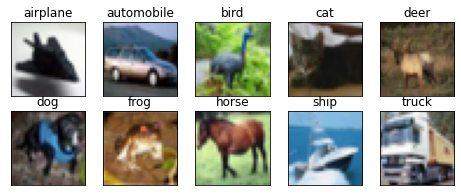

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
num_classes = 10
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    img = next(img for img, label in train_cifar10 if label == i)
    plt.imshow(img.permute(1, 2, 0)) # torch.Size([32, 32, 3])
plt.show()

In [ ]:
# Examine the tensor of a truck image
print(img.shape)
print(img)

torch.Size([3, 32, 32])
tensor([[[0.6039, 0.4941, 0.4118,  ..., 0.3569, 0.3412, 0.3098],
         [0.5490, 0.5686, 0.4902,  ..., 0.3765, 0.3020, 0.2784],
         [0.5490, 0.5451, 0.4510,  ..., 0.3098, 0.2667, 0.2627],
         ...,
         [0.6863, 0.6118, 0.6039,  ..., 0.1647, 0.2392, 0.3647],
         [0.6471, 0.6118, 0.6235,  ..., 0.4039, 0.4824, 0.5137],
         [0.6392, 0.6196, 0.6392,  ..., 0.5608, 0.5608, 0.5608]],

        [[0.6941, 0.5373, 0.4078,  ..., 0.3725, 0.3529, 0.3176],
         [0.6275, 0.6000, 0.4902,  ..., 0.3882, 0.3137, 0.2863],
         [0.6078, 0.5725, 0.4510,  ..., 0.3216, 0.2745, 0.2706],
         ...,
         [0.6549, 0.6039, 0.6275,  ..., 0.1333, 0.2078, 0.3255],
         [0.6039, 0.5961, 0.6314,  ..., 0.3647, 0.4471, 0.4745],
         [0.5804, 0.5804, 0.6118,  ..., 0.5216, 0.5255, 0.5216]],

        [[0.7333, 0.5333, 0.3725,  ..., 0.2784, 0.2784, 0.2745],
         [0.6627, 0.6039, 0.4627,  ..., 0.3059, 0.2431, 0.2392],
         [0.6431, 0.5843, 0.4392, 

In [ ]:
# Examine the mean and std of images in the training data
imgs = torch.stack([img_t for img_t, label in train_cifar10], dim = 3)
print(imgs.view(3,-1).mean(dim=1),imgs.view(3,-1).std(dim=1))

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


In [ ]:
# Define the image preprocessing pipeline to include normalization
cifar10_trans = transforms.Compose([        # composes several transforms together
    transforms.Resize((32, 32)),
    transforms.ToTensor(), # ToTensor() converts images to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
    transforms.Normalize(mean = [0.4914, 0.4822, 0.4465], std = [0.2470, 0.2435, 0.2616])
])

In [ ]:
# Loading images and pass the images through our preprocessing pipeline
train_cifar10 = ImageFolder('/content/drive/MyDrive/DL_data/train_top10', transform=cifar10_trans)
test_cifar10 = ImageFolder('/content/drive/MyDrive/DL_data/test_top10', transform=cifar10_trans)


In [ ]:
# Define training and testing data loader, and set batch size to 256
train_loader_cifar10 = torch.utils.data.DataLoader(train_cifar10, batch_size=256, shuffle=True)
test_loader_cifar10 = torch.utils.data.DataLoader(test_cifar10, batch_size=256, shuffle=False)

In [ ]:
# Build a neural network on training data
class neural_network(nn.Module):
    def __init__(self,  in_size, hidden_size1, hidden_size2, out_size):
        super().__init__()
        self.network = nn.Sequential(
          nn.Linear(in_size, hidden_size1),
          nn.ReLU(),
          nn.Linear(hidden_size1, hidden_size2),
          nn.ReLU(),
          nn.Linear(hidden_size2, out_size))

    def forward(self, x):
        x_reshape = x.view(x.shape[0], -1)
        out = self.network(x_reshape)
        return out

In [ ]:
# Define training loop function
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(0, n_epochs):
        # Training Phase 
        model.train()
        loss_train = 0.0
        for inputs, labels in train_loader:

            outputs = model(inputs)
            
            loss = loss_fn(outputs, labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 0 or epoch == n_epochs-1 or epoch % 1 == 0:
            print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))

In [ ]:
# Model training
torch.manual_seed(0)
model = neural_network(32*32*3, 256, 64, 10)
optimizer_adam = optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs= 20, optimizer = optimizer_adam, model = model, loss_fn = loss_fn, train_loader = train_loader_cifar10)


Epoch 0, Training loss 1.9712810516357422
Epoch 1, Training loss 1.3118708372116088
Epoch 2, Training loss 1.006474506855011
Epoch 3, Training loss 0.7830998420715332
Epoch 4, Training loss 0.6200978279113769
Epoch 5, Training loss 0.4988025963306427
Epoch 6, Training loss 0.3866418957710266
Epoch 7, Training loss 0.31270968317985537
Epoch 8, Training loss 0.24313029944896697
Epoch 9, Training loss 0.17941041886806489
Epoch 10, Training loss 0.13935464024543762
Epoch 11, Training loss 0.1075414165854454
Epoch 12, Training loss 0.08250859677791596
Epoch 13, Training loss 0.06422021463513375
Epoch 14, Training loss 0.04649195596575737
Epoch 15, Training loss 0.035168585181236264
Epoch 16, Training loss 0.028816591948270798
Epoch 17, Training loss 0.022863221541047096
Epoch 18, Training loss 0.01882870402187109
Epoch 19, Training loss 0.015906110964715482


In [ ]:
# Define testing function
def test(model, train_loader, test_loader):
 
  # testing phase
  model.eval()
  predict_train = []
  predict_test = []
  labels_train = []
  labels_test = []

  with torch.no_grad():
      for inputs, labels in train_loader:
          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_train.append(predicted.tolist())
          labels_train.append(labels.tolist())

      for inputs, labels in test_loader:
          outputs = model(inputs)
          index_, predicted = torch.max(outputs, dim=1)
          predict_test.append(predicted.tolist())
          labels_test.append(labels.tolist())

  print("Confusion matrix on train:\n",  confusion_matrix(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on train:\n",  classification_report(list(chain(*labels_train)), list(chain(*predict_train)), labels=[0, 1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Confusion matrix on test:\n",  confusion_matrix(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
  print()
  print("Classification report on test:\n",  classification_report(list(chain(*labels_test)), list(chain(*predict_test)), labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))


In [ ]:
# Examine evaluation results
test(model, train_loader_cifar10, test_loader_cifar10)

Confusion matrix on train:
 [[121   0   0   0   0   0   0   0   0   0]
 [  0 107   0   0   0   0   0   0   0   0]
 [  0   0 128   0   0   0   0   0   0   0]
 [  0   0   0 129   0   0   0   0   0   0]
 [  0   0   0   0 120   0   0   0   0   0]
 [  0   0   0   0   0 120   0   0   0   0]
 [  0   0   0   0   0   0 120   0   0   0]
 [  0   0   0   0   0   0   0 115   0   0]
 [  0   0   0   0   0   0   0   0 107   0]
 [  0   0   0   0   0   0   0   0   0 108]]

Classification report on train:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       107
           0       1.00      1.00      1.00       121
           1       1.00      1.00      1.00       107
           2       1.00      1.00      1.00       128
           3       1.00      1.00      1.00       129
           4       1.00      1.00      1.00       120
           5       1.00      1.00      1.00       120
           6       1

In [ ]:
# Generate a html file
!jupyter nbconvert --to html "/content/drive/MyDrive/DL_Lab/Lab8_Learning_from_Images.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/DL_Lab/Lab8_Learning_from_Images.ipynb to html
[NbConvertApp] Writing 1043016 bytes to /content/drive/MyDrive/DL_Lab/Lab8_Learning_from_Images.html
